# **Data 311 - Final Project**

# **Music Through the Eyes of Machines**
### *Discovering Patterns Across Musical Genres*

### **Group Members**
#### Steve Ramirez
#### Theo Hytopoulos
#### Andrew Cox

## Objective: Given a set of musical features, can we predict what genre a given song belongs to?

## **Part 1: Predicting Popularity With Audio Features**

During our initial foray into the Spotify API, we posed this question: Can we create a predictive model to estimate a song's popularity, based solely upon its musical features?


The Spotify API provides several audio features for each track. This is how Spotify has defined them:

**Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.

**Instrumentalness**: Predicts whether a track contains no vocals. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**Loudness**: The overall loudness of a track in decibels (dB).

**Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

**Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


Our hypothesis is that these attributes may influence a track's likelihood to be more or less popular.

In [ ]:
#@title import libraries

!pip install deeznutz
import deeznutz as dn

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import scipy
import matplotlib
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Setup user key and necessary packages to make api calls

!pip install kaggle | grep -v 'already satisfied'
!mkdir -p ~/.kaggle
!echo '{"username":"theohh","key":"e49655b1bb259c87281cc0985c054a77"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Download dataset from kaggle

!kaggle datasets download -d yamaerenay/spotify-dataset-19212020-600k-tracks
!unzip -o /content/spotify-dataset-19212020-600k-tracks.zip

artists_df = pd.read_csv("/content/artists.csv")
tracks_df = pd.read_csv("/content/tracks.csv")

# get primary artist
tracks_df['artist1'] = tracks_df['id_artists'].map(lambda x: eval(x)[0])

# remove live tracks
tracks_df = tracks_df[tracks_df['liveness'] < 0.8]

# grab only tracks from the 90s
tracks_df['year'] = pd.to_datetime(tracks_df['release_date']).dt.year
tracks_df = tracks_df[(tracks_df['year'] > 1990) & (tracks_df['year'] < 2000)]

# Create samples
sample = tracks_df.sample(1000)
Xall = sample[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']]
yall = sample['popularity']

spotify-dataset-19212020-600k-tracks.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/spotify-dataset-19212020-600k-tracks.zip
  inflating: artists.csv             
  inflating: dict_artists.json       
  inflating: tracks.csv              


We refined the dataset by limiting the tracks to a specific timeframe (the 90s) and removing live tracks, which we felt would have odd and outlying audio qualities.

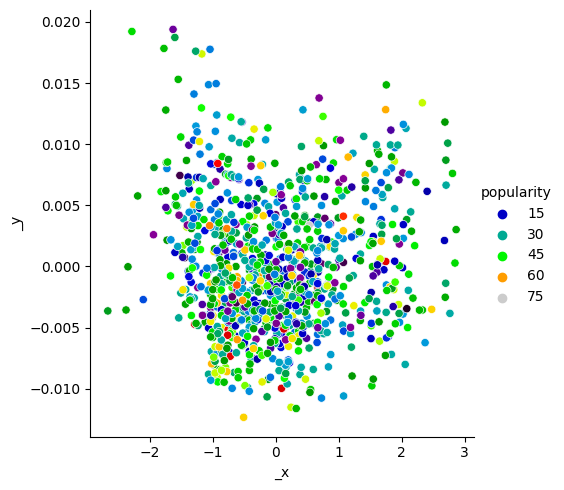

In [ ]:
#@title Perform PCA on popularity features

pca = PCA(n_components=2)

norm = np.sqrt(Xall['danceability'].var() + Xall['tempo'].var())

Xall.loc[:,'danceability_norm'] = Xall['danceability'].map(lambda x: x / norm)
Xall.loc[:,'tempo_norm'] = Xall['tempo'].map(lambda x: x / norm)

arr = np.c_[Xall[['danceability_norm', 'tempo_norm']]]
pca.fit(arr)

Xprime = pca.transform(arr)
sns.relplot(data=Xprime, x=Xprime[:,0], y=Xprime[:, 1], hue=yall, palette='nipy_spectral')
plt.show()

Performing PCA on the cleaned up dataframe gave disappointing results. Plotting the transformed data showed no clustering behavior or distinction between popularity. Limiting ourselves to just two components gave us the same results.

Drawing upon this, we were forced to conclude that we can not reliably determine a song's popularity solely on audio features alone. Our interpretation is that this is a testament to the diversity of individual musical tastes in society. This steered us into looking at other contexts where audio features may be a determining factor.

## **Part 2: Pivoting to Genres**

Upon reviewing the results, we decided to take a look at the relationship between genre and audio features. These kinds of properties are at the core of what sets genres apart from one another.

After pulling a list of genres from Spotify, we noticed quite a few categories that described a variety of genres. These were filtered out to avoid unnecessary convolution of our analysis.

In [ ]:
#@title Setup spotify API

!pip install urllib3 | grep -v 'already satisfied'
!pip install requests | grep -v 'already satisfied'
!pip install spotipy | grep -v 'already satisfied'

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import random
import pandas as pd

client_id = "9a154035765d42eb9579f3cca3c76727"
client_secret = "4802d4e15e584b0a853da11356b99735"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))
# Get all genres Spotify provides
genres = sp.recommendation_genre_seeds()['genres']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
bad_genres = ['comedy',  'children', 'dance', 'disney', 'happy', 'holidays', 'kids', 'movies', 'new-release', 
              'pop-film', 'rainy-day', 'road-trip', 'romance', 'sad', 'study', 'sleep', 'work-out', 'summer', 'soundtracks']
genres = [genre for genre in genres if genre not in bad_genres]

In [ ]:
#@title Example of genres provided by Spotify
random.sample(genres, 10)

['death-metal',
 'post-dubstep',
 'honky-tonk',
 'sertanejo',
 'house',
 'psych-rock',
 'j-dance',
 'chill',
 'grunge',
 'trip-hop']

In [ ]:
#@title Retrieve tracks
# Grab 200 "recommended" songs from x genres
tracks = {}
for genre in random.sample(genres, NUM_GENRES):
  tracks[genre] = sp.recommendations(seed_genres=[genre], limit=100)
  tracks[genre].update(sp.recommendations(seed_genres=[genre], limit=100))

After several combinations of audio features, we identified danceability, acousticness, and instrumentalness as the most influential attributes between genres. The inclusion of other features, such as key and valence, showed worse performance. We believe this is because they did not have any correlation to genre.

In [ ]:
NUM_GENRES = 5

In [ ]:
attributes = ['danceability', 
              'acousticness', 
              'instrumentalness']

In [ ]:
#@title
dfs = {}
num = 1
for g in tracks:
  df = pd.DataFrame()
  for track in tracks[g]['tracks']:
    features = sp.audio_features(track['uri'])
    df = pd.concat([df, pd.DataFrame().from_dict(features)])
  df["g_num"] = num
  num += 1
  dfs[g] = df

all_3d = pd.DataFrame()
for df in dfs:
  all_3d = pd.concat([all_3d, dfs[df]])
all = all_3d[attributes].abs()

# normalize values
scaler = StandardScaler()
all_norm = scaler.fit_transform(all)

### Performing PCA

After running PCA, we can see that there is not a reliable distinction between randomly sampled genres. PCA consolidated a majority of the points together, leaving only a cloud of points corresponding to jazz and blues. These genres tend to be more musically adventerous than others, so this doesn't come as a surprise.

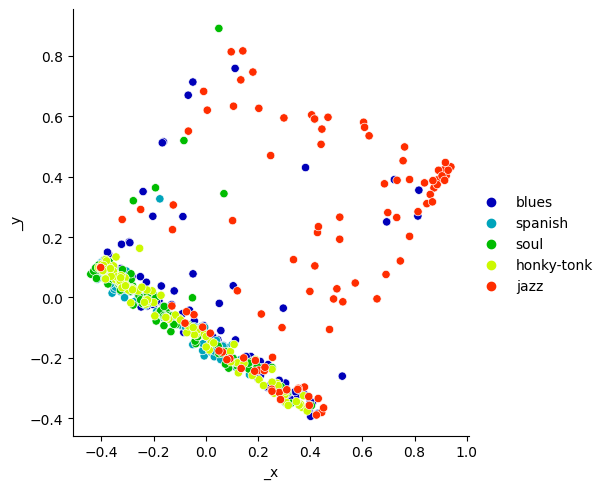

In [ ]:
#@title

pca = PCA(n_components=2)

g = []
n = []
for (i,x) in zip(dfs, range(len(dfs))):
  for j in range(len(dfs[i])):
    g.append(i)
    n.append(x)

arr = np.c_[all[attributes]]
pca.fit(arr)

Xprime = pca.transform(arr)
sns.relplot(data=Xprime, x=Xprime[:,0], y=Xprime[:, 1], palette='nipy_spectral', hue=g)
plt.show()

Looking at a higher dimensional plot from different perspectives provides more detailed analysis of the overlap between genres.

### Higher Dimensional PCA

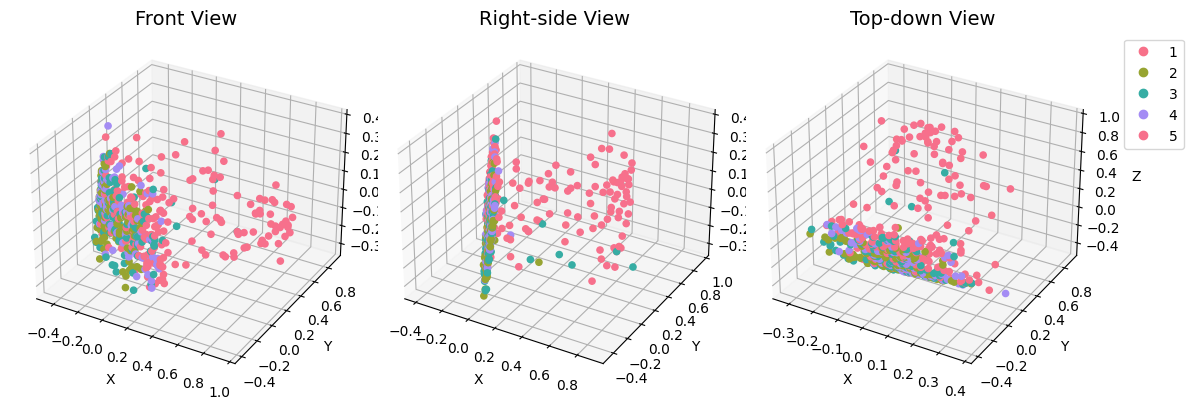

In [ ]:
#@title

# perform PCA
pca = PCA(n_components=3)
pca.fit(arr)
Xprime = pca.transform(arr)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(12,4))

def make_3d_view(fig, n, title, x, y, z):
  """ Plot 3D view of PCA """

  ax = fig.add_subplot(1, 3, n, projection='3d')
  fig.add_axes(ax)

  sc = ax.scatter(x, y, z, marker='o', cmap=cmap, alpha=1, c=all_3d['g_num'])
  ax.set_xlabel('X', fontsize=10)
  ax.set_ylabel('Y', fontsize=10)
  ax.set_zlabel('Z', fontsize=10)
  ax.set_title(title, fontsize=14)
  return sc

sc = make_3d_view(fig, 1, 'Front View', Xprime[:,0], Xprime[:,1], Xprime[:,2])
sc = make_3d_view(fig, 2, 'Right-side View', Xprime[:,1], Xprime[:,0], Xprime[:,2])
sc = make_3d_view(fig, 3, 'Top-down View', Xprime[:,2], Xprime[:,1], Xprime[:,0])

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
fig.tight_layout()
plt.show()

### DBSCAN

Using a method called DBSCAN (Density-Based Spatial Clustering of Applications with Noise), reveals interesting results. This method aims to cluster data together based on proximity and distinguishing them from noise. DBSCAN is able to identify a high level of noise. However, it unfortunately cannot tease apart the overlapping genres and instead predicts them as a single cluster.

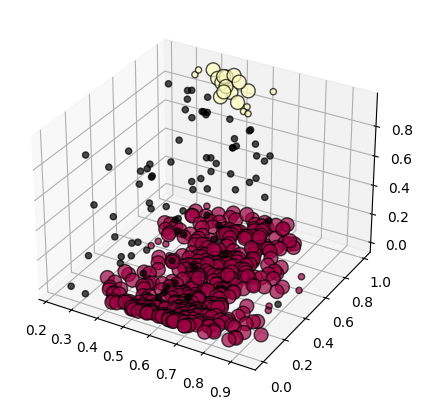

In [ ]:
#@title

def perform_dbscan(arr):

  db = DBSCAN(eps=0.1, min_samples=6).fit(arr)

  unique_labels = set(db.labels_)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True

  colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
  fig = plt.figure(figsize=(5,5))
  ax = fig.add_subplot(111, projection='3d')
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      class_member_mask = db.labels_ == k

      xyz = arr[class_member_mask & core_samples_mask]
      ax.scatter(
          xyz[:, 0],
          xyz[:, 1],
          xyz[:, 2],
          color=col,
          edgecolor="k",
          s=100,
          alpha=0.7,
          depthshade=True,
      )

      xyz = arr[class_member_mask & ~core_samples_mask]
      ax.scatter(
          xyz[:, 0],
          xyz[:, 1],
          xyz[:, 2],
          color=col,
          edgecolor="k",
          s=20,
          alpha=0.7,
          depthshade=True,
      )
  plt.show()

perform_dbscan(arr)

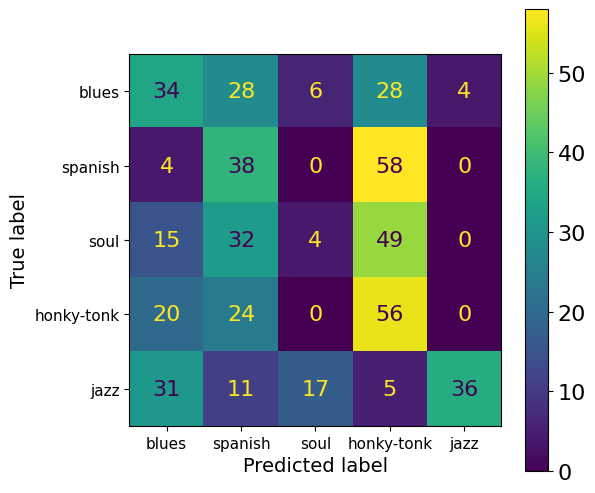

In [ ]:
#@title

def make_confusion(features, labels):
  km = KMeans(n_clusters=len(dfs), n_init='auto')
  km.fit(features)
  M = sklearn.metrics.confusion_matrix(labels, km.labels_)
  return M

def rearrange_confusion(conf):
  """ Match cluster centers to labels so that the ideal confusion matrix
  is diagonal. """
  ri, ci = scipy.optimize.linear_sum_assignment(conf, maximize=True)
  return conf[:, ci]

names = []
for key in dfs.keys():
  names.append(key)

conf = make_confusion(all, n)
conf_re = rearrange_confusion(conf)

fig, ax = plt.subplots(figsize=(6,6))
ax.tick_params(axis='both', which='both', labelsize=11)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.grid(False)

matplotlib.rcParams.update({'font.size': 16})
cmp = sklearn.metrics.ConfusionMatrixDisplay(conf_re, display_labels=names)
cmp.plot(ax=ax)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

We chose the following metrics to measure the performance of our model:
* **Confusion Matrix**: A visualization of the model's predictive performance.
* **Silhouette Score**: Measures how well each data point fits into its assigned cluster compared to other nearby clusters (*Higher silhouette scores indicate better clustering performance*).
* **Calinski Harabasz Score**: Measures the ratio of the between-cluster variance to the within-cluster variance (*Higher values indicate better clustering performance*).
* **Davies Bouldin Score**: Measures the average similarity between each cluster and its most similar cluster, relative to the average similarity between each cluster and its least similar cluster (*Lower values indicate better clustering performance*).

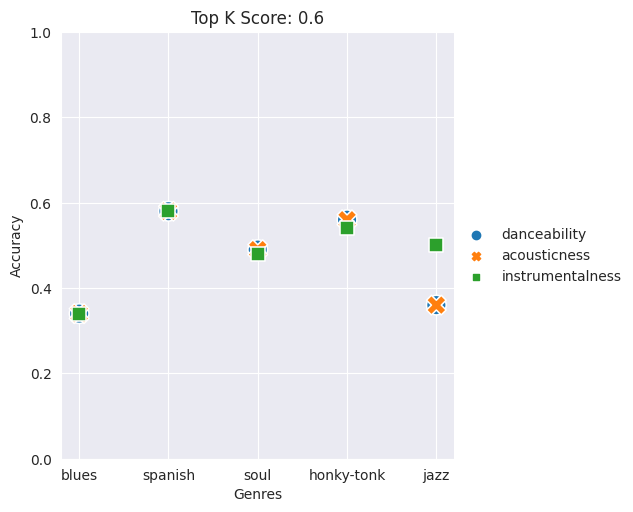

In [ ]:
#@title You get a Metric! You get a Metric! Everybody gets a Metric!!
from sklearn.metrics import top_k_accuracy_score

accuracy = pd.DataFrame()

for i in all:
  conf = make_confusion(all, n)
  conf_re = rearrange_confusion(conf)
  temp = []
  for j in range(NUM_GENRES):
    temp.append(conf_re[j].max()/conf_re[j].sum())
  accuracy[i] = temp

plt.figure(figsize=[15,10])

plt.clf()
plt.close()

sns.set_style('darkgrid')

sns.relplot(data=accuracy, s=200)

plt.xticks(range(len(names)), names)
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.title("Feature Accuracy Across Genres")
plt.ylim(0, 1)
plt.show()

In [ ]:
#@title Calculate Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(all, n)
print("silhouette score:", sil_score)
cal_score = calinski_harabasz_score(all, n)
print("calinski harabasz score:", cal_score)
dav_score = davies_bouldin_score(all, n)
print("davies bouldin score:", dav_score)

silhouette score: -0.06066994821962362
calinski harabasz score: 51.020885188506455
davies bouldin score: 6.8094248673537106


## **Part 3: Taking High-Level Genres ONLY**

Even though the genres have been filtered for ambiguity, there still exists a high amount of overlap between what we intend to be distinct genres. Our solution is to pick several high level genres that take less influence from each other.
Since one of our features is acousticness, we also decided to restrict the dataframe to tracks released before 2000. Before we added this restriction, the electronic genre had overlap with most other genres. We suspect this is because newer songs are more likely to be composed in a digital workspace in contrast to an in-studio performance.

In [ ]:
short_genres = [
    'electronic',
    'metal',
    'hip-hop',
    'bluegrass',
    'classical']

In [ ]:
#@title

# Grab 200 "recommended" songs from x genres
tracks = {}
for genre in random.sample(short_genres, NUM_GENRES):
  tracks[genre] = []
  while len(tracks[genre]) < 200:
    t = sp.recommendations(seed_genres=[genre], limit=100)['tracks']
    t = [track for track in t if pd.to_datetime(track['album']['release_date']).year < 2000]
    tracks[genre] = tracks[genre] + t

for g in tracks:
  tracks[g] = tracks[g][:200]

In [ ]:
#@title

# retrieve all tracks
dfs = {}
num = 1
for g in tracks:
  df = pd.DataFrame()
  for track in tracks[g]:
    features = sp.audio_features(track['uri'])
    df = pd.concat([df, pd.DataFrame().from_dict(features)])
  df["g_num"] = num
  num += 1
  dfs[g] = df

# create dataframe
all_3d = pd.DataFrame()
for df in dfs:
  all_3d = pd.concat([all_3d, dfs[df]])
all = all_3d[attributes].abs()

# normalize values
scaler = StandardScaler()
all_norm = scaler.fit_transform(all)

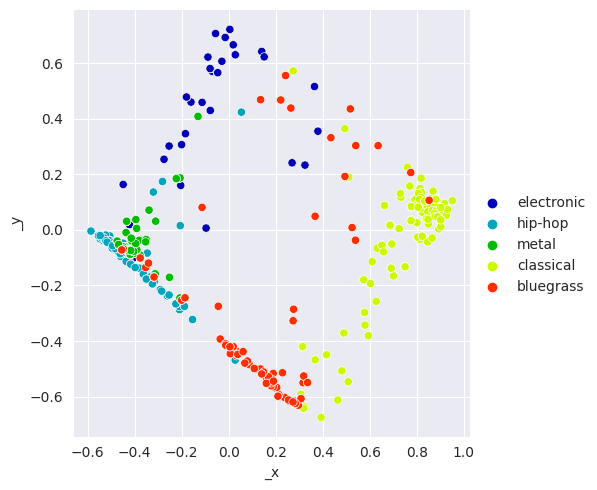

In [ ]:
#@title Perform PCA

pca = PCA(n_components=2)

# norm = np.sqrt(Xall['danceability'].var() + Xall['tempo'].var())

# Xall['danceability_norm'] = Xall['danceability'].map(lambda x: x / norm)
# Xall['tempo_norm'] = Xall['tempo'].map(lambda x: x / norm)

g = []
n = []
for (i,x) in zip(dfs, range(len(dfs))):
  for j in range(len(dfs[i])):
    g.append(i)
    n.append(x)

# arr = np.c_[all_norm[attributes]]
arr = np.c_[all[attributes]]
#np.abs(arr)
pca.fit(arr)

Xprime = pca.transform(arr)
sns.relplot(data=Xprime, x=Xprime[:,0], y=Xprime[:, 1], palette='nipy_spectral', hue=g)
plt.show()

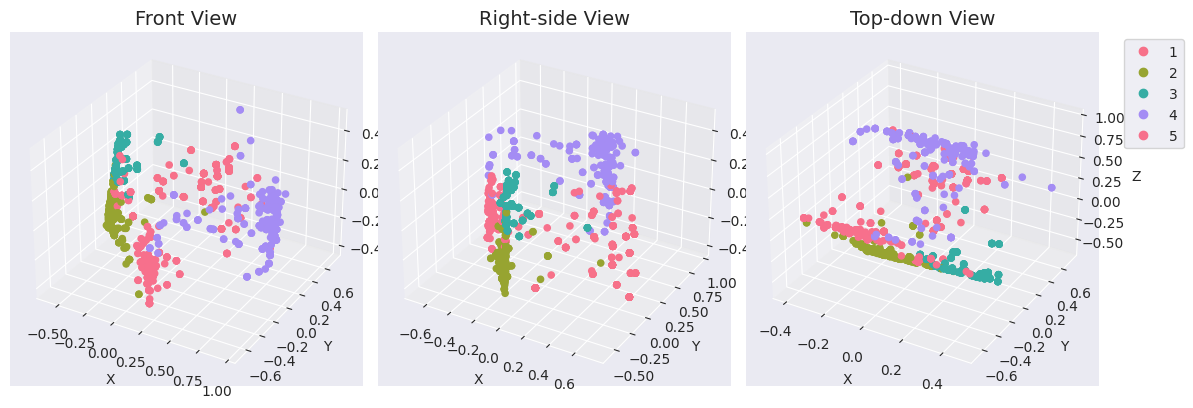

In [ ]:
#@title

# perform PCA
pca = PCA(n_components=3)
pca.fit(arr)
Xprime = pca.transform(arr)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
fig = plt.figure(figsize=(12,4))

sc = make_3d_view(fig, 1, 'Front View', Xprime[:,0], Xprime[:,1], Xprime[:,2])
sc = make_3d_view(fig, 2, 'Right-side View', Xprime[:,1], Xprime[:,0], Xprime[:,2])
sc = make_3d_view(fig, 3, 'Top-down View', Xprime[:,2], Xprime[:,1], Xprime[:,0])

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
fig.tight_layout()
plt.show()

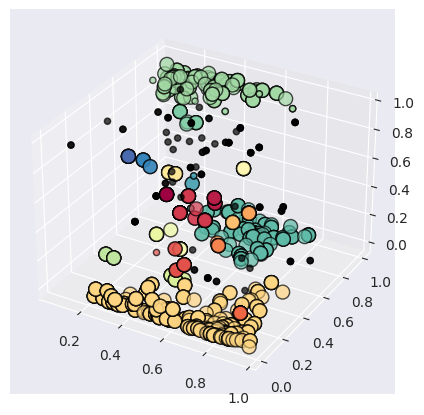

In [ ]:
perform_dbscan(arr)

Both DBSCAN and KMeans are able to do a better job of predicting clusters from the data.

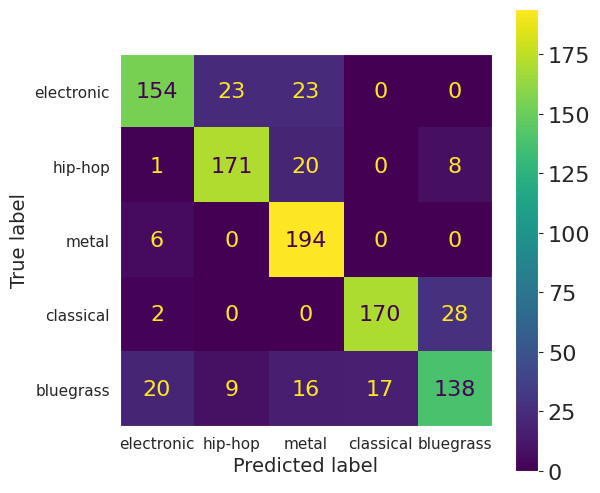

In [ ]:
#@title Plot confusion matrix

def make_confusion(features, labels):
  
  km = KMeans(n_clusters=len(dfs), n_init='auto',init='k-means++', random_state=99)
  km.fit(features)
  M = sklearn.metrics.confusion_matrix(labels, km.labels_)
  return M

def rearrange_confusion(conf):
  """ Match cluster centers to labels so that the ideal confusion matrix
  is diagonal. """
  ri, ci = scipy.optimize.linear_sum_assignment(conf, maximize=True)
  return conf[:, ci]

names = []

for key in dfs.keys():
  names.append(key)

conf = make_confusion(all, n)
conf_re = rearrange_confusion(conf)

fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(axis='both', which='major', labelsize=11)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.grid(False)

matplotlib.rcParams.update({'font.size': 16})
cmp = sklearn.metrics.ConfusionMatrixDisplay(conf_re, display_labels=names)
cmp.plot(ax=ax)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

We also observe better performance across all metrics.

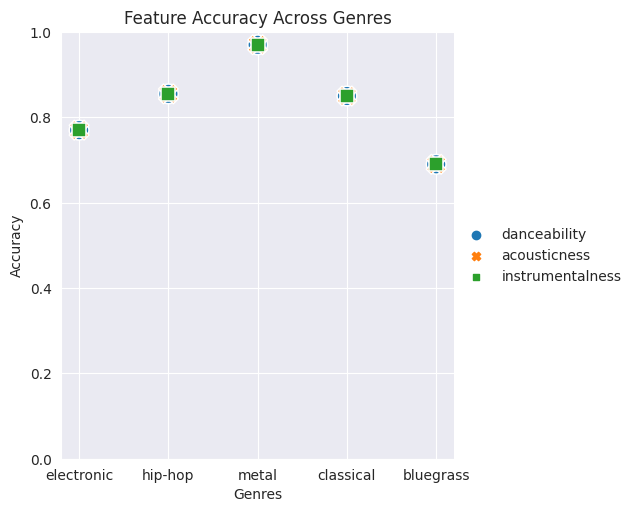

In [ ]:
#@title You get a Metric! You get a Metric! Everybody gets a Metric!!
from sklearn.metrics import top_k_accuracy_score

accuracy = pd.DataFrame()

for i in all:
  conf = make_confusion(all, n)
  conf_re = rearrange_confusion(conf)
  temp = []
  for j in range(5):
    temp.append(conf_re[j].max()/conf_re[j].sum())
  accuracy[i] = temp

plt.figure(figsize=[15,10])

plt.clf()
plt.close()

sns.set_style('darkgrid')

sns.relplot(data=accuracy, s=200)

plt.xticks(range(len(names)), names)
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.title("Feature Accuracy Across Genres")
plt.ylim(0, 1)
plt.show()

In [ ]:
#@title Calculate Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

sil_score = silhouette_score(all, n)
print("silhouette score:", sil_score)
cal_score = calinski_harabasz_score(all, n)
print("calinski harabasz score:", cal_score)
dav_score = davies_bouldin_score(all, n)
print("davies bouldin score:", dav_score)

silhouette score: 0.3704672457788707
calinski harabasz score: 662.3665276622279
davies bouldin score: 0.9212940142598974


## Part 4: Insights and Positive Affirmations

While genres tend to have distinct features overall, they begin to exhibit an increasing amount of overlap as more sub-genres and/or closely related genres are introduced. The noise within the machine learning model increases as genre relations become less and less distinct. However, with a genre pool of high-level classifications that are able to encompass a wider range of audio features, the distinctions between genres becomes more apparent, allowing the model to make more accurate determinations, given correlated audio features. 

For example, 'electronic' music covers a wide range of genres, such as 'techno,' 'edm,' 'house,' and 'dub-step.' When these related genres are introduced into the data set as unique genres, it introduces unnecessary noise into the model, further confusing the results. 

As we increased the number of tracks being analyzed, we observed the accuracy of the model's predictions improved and variance decreased. Given this observation, it follows that larger sample sizes may provide enough granularity to allow for accurate grouping and predictive power for sub-genres. 

On that note, we will leave you to ponder the potentially limitless power our machine overlords may grow to possess in the coming years. 

Be excellent to each other, and party on, dudes. 🤘